In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from library.sb_utils import save_file

from sklearn.preprocessing import StandardScaler

In [38]:
# Load the data from EDA

%store -r electric_rwc
%store -r weather_rwc

# Feature Engineering

We can create two features from the weather data:

Heating Degree Days (HDD)
Cooling Degree Days (CDD)

These are standard measures meant to quantify the amount of heating or cooling needed on a given day. They are derived from the average daily temperature.

Definition and description can be found here:
https://www.weather.gov/key/climate_heat_cool

In [34]:
def calc_hdd_cdd(df):
    '''Takes a DataFrame with columns TMAX and TMIN in degrees C.
    Returns the same DataFrame with TAVG_C, TAVG_F, HDD, and CDD columns added.'''

    df['TAVG_C'] = (df['TMAX'] + df['TMIN'])/2
    df['TAVG_F'] = df['TAVG_C'] * 9/5 + 32
    df['HDD'] = np.maximum(65 - df['tavg_f'] , 0)
    df['CDD'] = np.maximum(df['tavg_f']  - 65, 0)

    return df

In [39]:
weather_rwc = calc_hdd_cdd(weather_rwc)

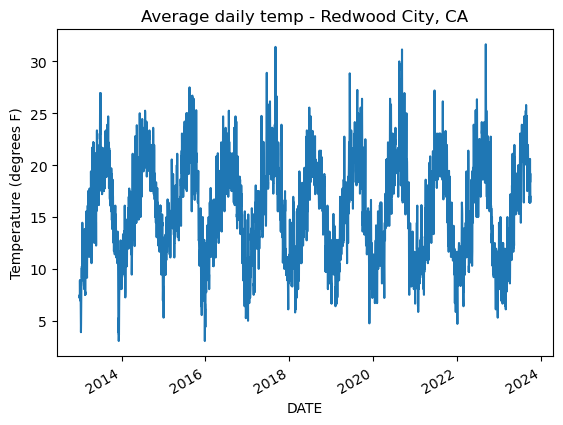

In [36]:
weather_rwc['TAVG_C'].plot()
plt.title('Average daily temp - Redwood City, CA')
plt.ylabel('Temperature (degrees F)')
plt.show()

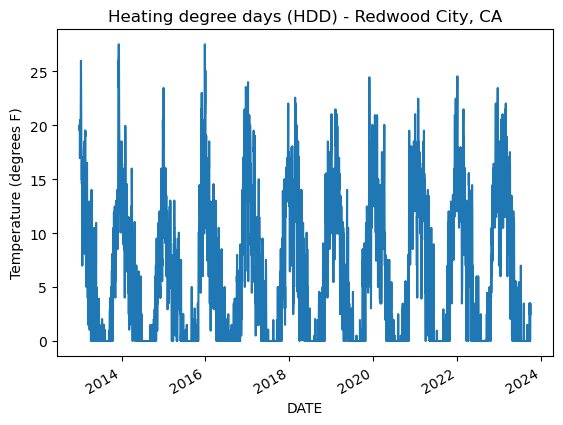

In [30]:
weather_rwc['HDD'].plot()
plt.title('Heating degree days (HDD) - Redwood City, CA')
plt.ylabel('Temperature (degrees F)')
plt.show()

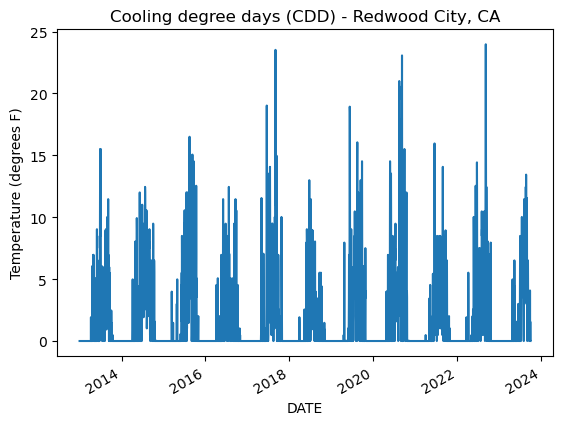

In [32]:
weather_rwc['CDD'].plot()
plt.title('Cooling degree days (CDD) - Redwood City, CA')
plt.ylabel('Temperature (degrees F)')
plt.show()

# Aggregate weather data

Our weather data has a daily frequency. We need to aggregate it by month in order to combine it with the monthly electrical usage data.

In [43]:
weather_rwc.head()

,TMAX,TMIN,HDD,CDD,TAVG_C,TAVG_F
DATE,,,,,,
2013-01-01,12.8,1.7,19.95,0.0,7.25,45.05
2013-01-02,15.6,-0.6,19.50,0.0,7.50,45.50
2013-01-03,14.4,0.0,20.04,0.0,7.20,44.96
2013-01-04,16.1,1.7,16.98,0.0,8.90,48.02
2013-01-05,12.2,2.2,20.04,0.0,7.20,44.96


In [47]:
weather_rwc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3923 entries, 2013-01-01 to 2023-09-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMAX    3923 non-null   float64
 1   TMIN    3923 non-null   float64
 2   HDD     3923 non-null   float64
 3   CDD     3923 non-null   float64
 4   TAVG_C  3923 non-null   float64
 5   TAVG_F  3923 non-null   float64
dtypes: float64(6)
memory usage: 214.5 KB


In [78]:
# create Series resampled to monthly frequency

hdd_monthly = weather_rwc['HDD'].resample('M', label='left').sum()
cdd_monthly = weather_rwc['CDD'].resample('M', label='left').sum()

In [75]:
hdd_monthly.head()

DATE
2012-12-31    512.73
2013-01-31    413.43
2013-02-28    266.01
2013-03-31    137.28
2013-04-30    107.25
Freq: M, Name: HDD, dtype: float64

In [79]:
# add one day to the index so it matches the electric data

hdd_monthly.index = hdd_monthly.index + pd.DateOffset(1)
cdd_monthly.index = cdd_monthly.index + pd.DateOffset(1)

In [101]:
# convert electric data to time series with datetime index

electric_ts = pd.DataFrame()
electric_ts['DATE'] = electric_rwc['Date']
electric_ts['AveragekWh'] = electric_rwc['AveragekWh']
electric_ts.drop_duplicates(subset='DATE', inplace=True) # we have some duplicates we didn't catch before
electric_ts.sort_values('DATE', inplace=True)
electric_ts.set_index('DATE', inplace=True)

In [102]:
electric_ts.head()

,AveragekWh
DATE,
2013-01-01,542.0
2013-02-01,440.0
2013-03-01,431.0
2013-04-01,391.0
2013-05-01,395.0


In [99]:
electric_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129 entries, 2013-01-01 to 2023-09-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AveragekWh  129 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [106]:
# join electric and weather data into a new combined dataframe

data_rwc = pd.DataFrame()
data_rwc['AveragekWh'] = electric_ts['AveragekWh']
data_rwc['HDD'] = hdd_monthly
data_rwc['CDD'] = cdd_monthly
data_rwc.index = electric_ts.index

In [107]:
data_rwc.head()

,AveragekWh,HDD,CDD
DATE,,,
2013-01-01,542.0,512.73,0.0
2013-02-01,440.0,413.43,0.0
2013-03-01,431.0,266.01,0.0
2013-04-01,391.0,137.28,21.9
2013-05-01,395.0,107.25,39.6


In [108]:
data_rwc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129 entries, 2013-01-01 to 2023-09-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AveragekWh  129 non-null    float64
 1   HDD         129 non-null    float64
 2   CDD         129 non-null    float64
dtypes: float64(3)
memory usage: 4.0 KB


# Scale the data

In [129]:
# Create scaled versions of the HDD and CDD freatures. These could be useful for modelling.

data_hddcdd = data_rwc[['HDD','CDD']]

scaler = StandardScaler()
scaler.fit(data_hddcdd)
data_hddcdd_sc = pd.DataFrame(data=scaler.transform(data_hddcdd))
data_hddcdd_sc.columns = ['HDD_sc', 'CDD_sc']
data_hddcdd_sc.index = data_hddcdd.index

In [131]:
data_rwc['HDD_sc'] = data_hddcdd_sc['HDD_sc']
data_rwc['CDD_sc'] = data_hddcdd_sc['CDD_sc']

In [132]:
data_rwc.head()

,AveragekWh,HDD,CDD,HDD_sc,CDD_sc
DATE,,,,,
2013-01-01,542.0,512.73,0.0,1.868594,-0.782745
2013-02-01,440.0,413.43,0.0,1.289173,-0.782745
2013-03-01,431.0,266.01,0.0,0.428970,-0.782745
2013-04-01,391.0,137.28,21.9,-0.322176,-0.432669
2013-05-01,395.0,107.25,39.6,-0.497403,-0.149730


In [133]:
# store and save for modelling

%store data_rwc

Stored 'data_rwc' (DataFrame)
